# EEG Seizure Clasficiation using 1D CNN
This project uses the **BONN EEG Dataset** to train a **1D convolution neural network (CNN)** to distinguish **seizure vs non seizure EEG segments**. 
The Bonn dataset contains EEG recordings from healthy volunteers and epilepsy patients, with segments labeled as seizure (ictal) or non-seizure (interictal/healthy). The goal is to demonstrate a deep learning approach for automated seizure detection from single-channel EEG data.


### Dataset

**Bonn EEG dataset** contains **five sets (A–E)**, each with 100 single-channel EEG segments (~23.6 seconds each, 4097 samples per segment, 173.61 Hz sampling rate).  

| Set | Description | Seizure? |
|-----|------------|-----------|
| A   | Healthy, eyes open | No |
| B   | Healthy, eyes closed | No |
| C   | Interictal, non-epileptogenic | No |
| D   | Interictal, epileptogenic | No |
| E   | Seizure (ictal) | Yes |

I will look specifically at distinguishing between ictal and interictal EEG segments, using datasets C, D and E. 

### Links:
- [Bonn EEG Dataset](https://www.upf.edu/web/ntsa/downloads/-/asset_publisher/xvT6E4pczrBw/content/2001-indications-of-nonlinear-deterministic-and-finite-dimensional-structures-in-time-series-of-brain-electrical-activity-dependence-on-recording-regi)
- [Original Paper: Andrzejak et al., 2001](https://www.upf.edu/documents/229517819/232450661/Andrzejak-PhysicalReviewE2001.pdf/0e9a54b8-8993-b400-743e-4d64fa29fb63)


### Goals

1. Load and preprocess EEG segments from all sets.  
2. Normalize and filter EEG signals.  
3. Prepare training and test datasets.  
4. Build and train a **1D CNN** to classify seizure vs non-seizure segments.  
5. Evaluate model performance using loss curves, accuracy and confusion matrix.  

In [ ]:

sys.path.append(os.path.abspath(".."))

import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import importlib

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.signal import butter, filtfilt

# import my functions
from scripts.preprocess import normalise_segments
from scripts.utils import plot_eeg_segment
from scripts.preprocess import load_and_preprocess

from scripts.train import train
from scripts.train import evaluate
importlib.reload(scripts.models)
from scripts.models import simple_EEG_MLP
from scripts.models import simple_EEG_CNN





## Load and Preprocess Data
- **Filtering:** Buttworth filter to remove high frequency noise above 40 Hz
- **Segmentation:** EEGs were segmented into 4 epochs, corresponding to around 6 seconds
- **Split into training/test datasets**: 80:20 split into training/test
- **Normalisation:** Segments were z-normalised based on training data 

In [ ]:
## Load and preprocess data
base_path = os.path.abspath("../data")

# 0:non-seizure, 1: seizure 
folders = {
    "C": 0,
    "D": 0, 
    "E": 1
}

X, y = load_and_preprocess(base_path, folders)

X = np.array(X) 
print("EEG segments shape:", X.shape)
y = np.array(y)
print("Labels shape:", y.shape)


# X: shape (1200, 1024), y: labels (0/1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Normalise data
X_train_normalised, X_test_normalised = normalise_segments(X_train, X_test)

EEG segments shape: (1200, 1024)
Labels shape: (1200,)
Train shape: (960, 1024)
Test shape: (240, 1024)


## Visualise EEG Segments and Normalisation

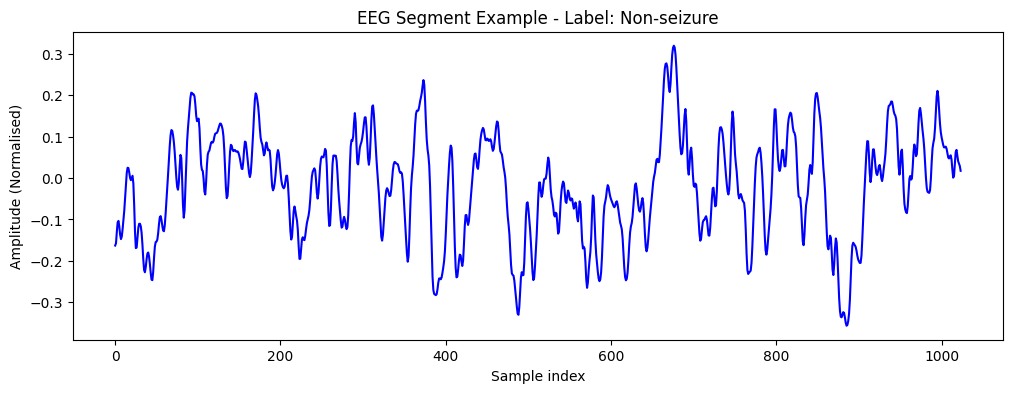

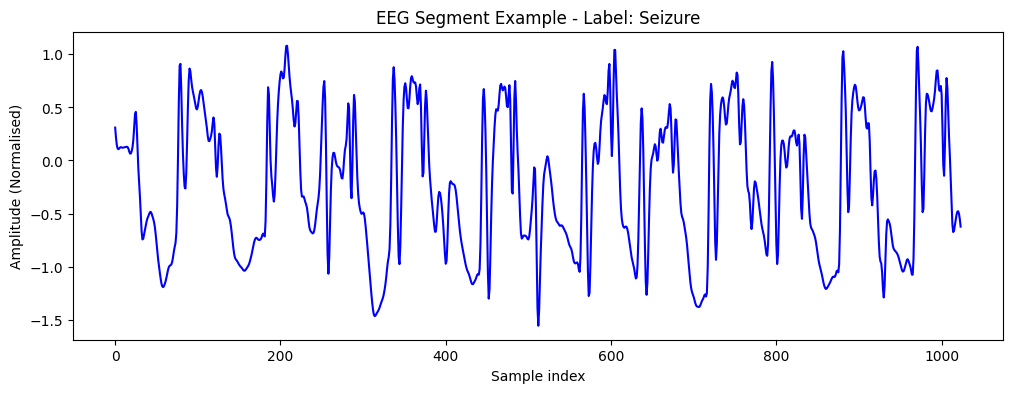

In [ ]:
# Visualise example of non-seizure normalised
segment = X_train_normalised[0]  
label = y_train[0]    
plot_eeg_segment(segment, label, num_samples = 1024, norm= True)


# Visualise example of seizure normalised
segment = X_train_normalised[2] 
label = y_train[2]    
plot_eeg_segment(segment, label, num_samples = 1024, norm= True)



## Simple Multi-Layer Perceptron: Baseline Model
**Overview:**
The Multi-Layer Perceptron (MLP) is a fully connected neural network where each input feature is connected to every neuron in the next layer. For EEG classification, the MLP treats the signal as a flat vector of values, without explicitly considering the order or temporal relationships of the data points.

**Pros:**
- Simple architecture: easy to implement and train
- Baseline performance: provides reference point to compare more complex CNN models
- Fewer hyperparameters

**Cons:**
- Ignores temporal structures: doesn't consider the local patterns of EEG
- Overfitting risk: fully connected layers can have many parameters relative to number of samples

**Motivation:**
By first training an MLP model, we can measure how much improvement is gained by 1D CNN models, which can detect temporal patterns and allows us to test pre-processing, training and evaluation pipelines on a simpler model before advancing to more complex models. 


In [72]:
# Convert NumPy arrays to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)  # (n_samples, 4097)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_ds = TensorDataset(X_train_torch, y_train_torch)
test_ds = TensorDataset(X_test_torch, y_test_torch)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)


Epoch 1/10 | Train Loss: 4.6402, Train Acc: 0.5740 | Val Loss: 1.3864, Val Acc: 0.7458
Epoch 2/10 | Train Loss: 1.4816, Train Acc: 0.7865 | Val Loss: 0.9501, Val Acc: 0.8000
Epoch 3/10 | Train Loss: 0.9642, Train Acc: 0.8625 | Val Loss: 0.9701, Val Acc: 0.8125
Epoch 4/10 | Train Loss: 0.6577, Train Acc: 0.8823 | Val Loss: 1.0357, Val Acc: 0.8333
Epoch 5/10 | Train Loss: 0.3875, Train Acc: 0.9187 | Val Loss: 0.7296, Val Acc: 0.8250
Epoch 6/10 | Train Loss: 0.3970, Train Acc: 0.9083 | Val Loss: 0.8051, Val Acc: 0.8292
Epoch 7/10 | Train Loss: 0.4696, Train Acc: 0.9135 | Val Loss: 0.8006, Val Acc: 0.8542
Epoch 8/10 | Train Loss: 0.2938, Train Acc: 0.9469 | Val Loss: 0.7711, Val Acc: 0.8583
Epoch 9/10 | Train Loss: 0.2924, Train Acc: 0.9406 | Val Loss: 1.4777, Val Acc: 0.8750
Epoch 10/10 | Train Loss: 0.4188, Train Acc: 0.9177 | Val Loss: 1.1534, Val Acc: 0.8542


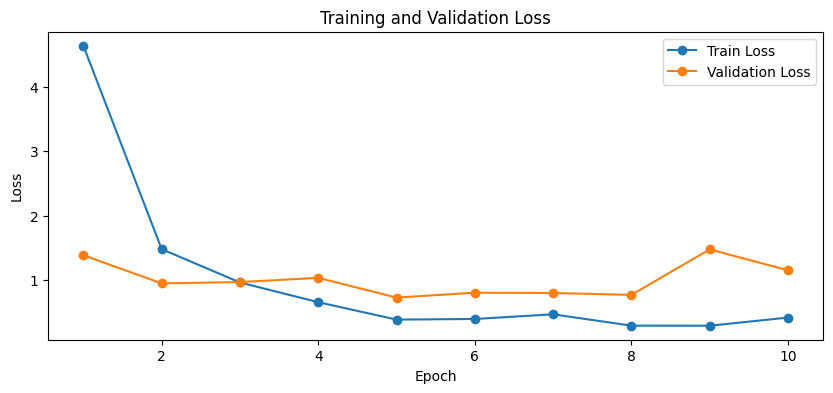

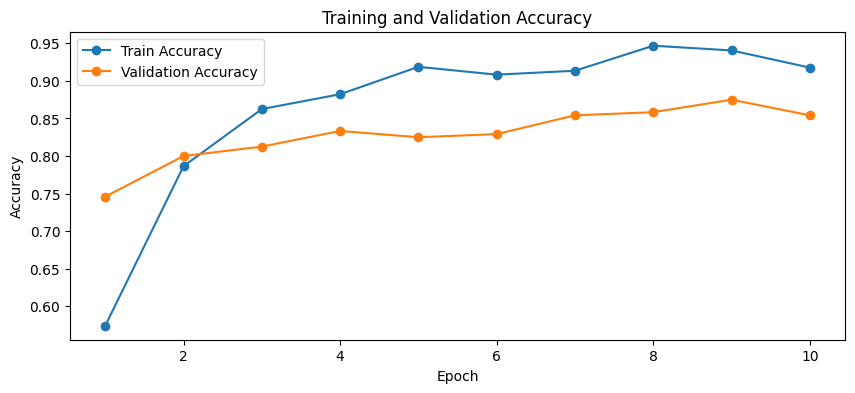

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = simple_EEG_MLP().to(device)
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3) # define optimisation algorithm

epochs = 10 # train the model for 10 full passes

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# train and evaluate each epoch
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, epochs=None)

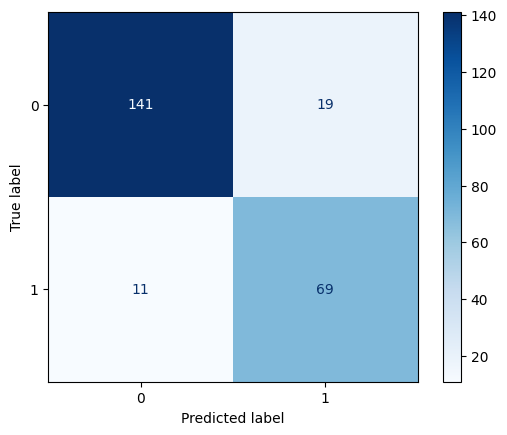

In [74]:
model.eval()  # set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)              # raw logits
        preds = torch.argmax(outputs, dim=1)  # predicted class
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# concatenate all batches
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues')


### Simple MLP Model Summary 
The simple MLP model served as a baseline model for EEG classification, treating each segment as a flattened vector thus ignoring temporal structure of EEG. Training over 10 epochs, the MLP quickly reduced training loss and attained a high training accuracy (~96%), while validation accuracy remained around 80-90% with fluctuating validation loss. This suggests overfitting to training data and low generalisability of this model to unseen data. 

Additionally, no hyper-parameter tuning was performed, with hyperparameters including learning rate, layer sizes and dropout chosen based on commonly used general values for similar tasks, providing a reasonable start point without extensive tuning. This model serves as a useful reference, with subsequent CNN models focused on learning temporal structures of EEG. 


## 1D Convolutional Neural Network

**Overview:**
The 1D convolutional neural network (CNN) is a neural network that applies convolutional filters along the temporal dimension of the EEG signal. For EEG classification, the 1D CNN treats the input as a sequence of time samples which allows the model to learn local temporal patterns that occur across short windows of the signal. Convolutional layers extract features and pooling layers reduce temporal resolution while retaining most important features. To improve training and prevent overfitting, the network includes batch normalisation, which normalises the activations within each layer to stabilises the learning process, and dropout which randomly deactivates neurons during training to improve generalisations. Fully connected layers at the end perform the final classification based on these learned representations. 

**Pros:**
- Captures temporal structure in EEG
- Faster and computationally efficient compared to more complex models such as Long Short-Term Memory networks (LSMTs)

**Cons:**
- More complex architecture and hyperparameters than MLP (e.g. filter sizes, number of channels, pooling strategies)
- Training can be slower than MLP

**Motivation:**
1D CNNs can use temporal changes in EEG signals, which can improve performance compared to our simpler MLP baseline

In [75]:
# Re-define torch tensors with additional dimension
X_train_torch = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (n_samples, 1, 4097)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_ds = TensorDataset(X_train_torch, y_train_torch)
test_ds = TensorDataset(X_test_torch, y_test_torch)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)


Epoch 1/10 | Train Loss: 0.2849, Train Acc: 0.9125 | Val Loss: 0.0627, Val Acc: 0.9875
Epoch 2/10 | Train Loss: 0.1486, Train Acc: 0.9510 | Val Loss: 0.0341, Val Acc: 0.9958
Epoch 3/10 | Train Loss: 0.2123, Train Acc: 0.9646 | Val Loss: 0.0891, Val Acc: 0.9833
Epoch 4/10 | Train Loss: 0.0634, Train Acc: 0.9812 | Val Loss: 0.0465, Val Acc: 0.9917
Epoch 5/10 | Train Loss: 0.0754, Train Acc: 0.9771 | Val Loss: 0.0649, Val Acc: 0.9875
Epoch 6/10 | Train Loss: 0.0391, Train Acc: 0.9844 | Val Loss: 0.0253, Val Acc: 0.9958
Epoch 7/10 | Train Loss: 0.0271, Train Acc: 0.9906 | Val Loss: 0.0449, Val Acc: 0.9917
Epoch 8/10 | Train Loss: 0.0485, Train Acc: 0.9854 | Val Loss: 0.0334, Val Acc: 0.9917
Epoch 9/10 | Train Loss: 0.0397, Train Acc: 0.9885 | Val Loss: 0.0273, Val Acc: 0.9958
Epoch 10/10 | Train Loss: 0.0552, Train Acc: 0.9833 | Val Loss: 0.0353, Val Acc: 0.9917


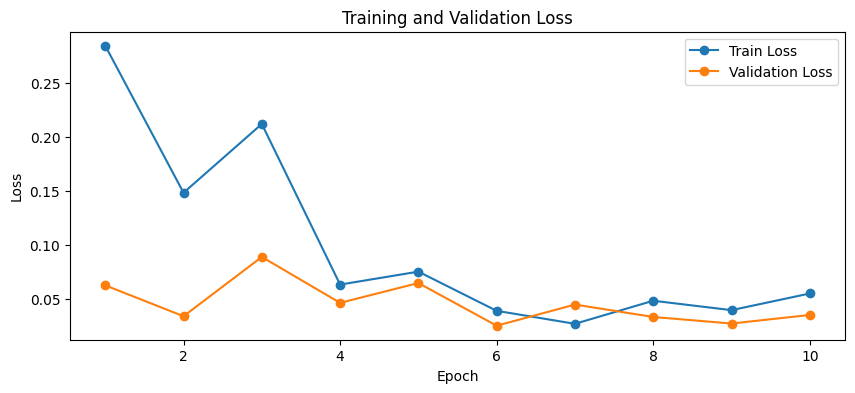

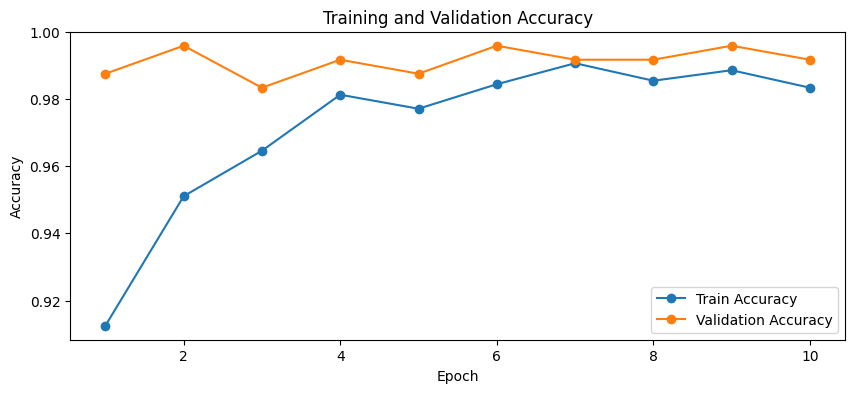

In [84]:
# calculate class weights- penalise misclassifying seizures more heavily
class_counts = np.bincount(y_train)
class_weights = 1. / class_counts
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = simple_EEG_CNN().to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3) # define optimisation algorithm

epochs = 10 # train the model for 10 full passes

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# train and evaluate each epoch
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, epochs=None)

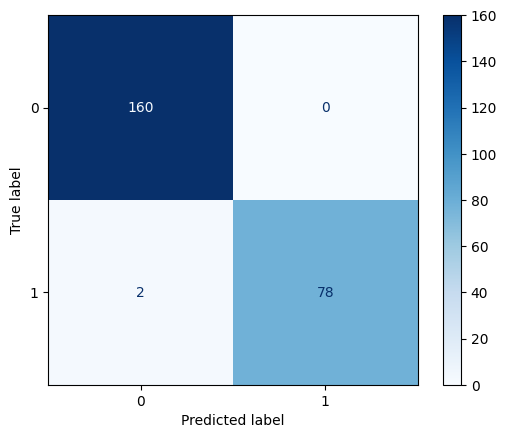

In [85]:
model.eval()  # set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)              # raw logits
        preds = torch.argmax(outputs, dim=1)  # predicted class
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# concatenate all batches
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues')


### 1D CNN Summary and Next Steps
Overall, the 1D CNN was highly effective at predicting seizure (ictal) vs non-seizure (interictal) segments. Training over 10 epochs, the CNN quickly reduced training loss (~0.05) and attained a high training accuracy (~98%), with validation set showing similar results (~ 0.03 loss, ~0.99 accuracy). From the confusion matrix, we can see that only 2 seizure EEG segments were misclassified as non-seizure EEG segments, though this may vary slightly across runs due to stochastic nature of CNN training and absence of a fixed random seed. To address the class imbalance between non-seizure segments and seizure segments (2:1), class weights were calculated and applied to the CrossEntropyLoss function. This ensured that misclassification of seizure segments was penalised more heavily, improving the model's ability to correctly detect seizures.

The CNN architecture, which included convolutional layers to capture temporal patterns, pooling to reduce dimensionality, batch normalisation to stabilise training, and dropout for regularisation contributed to the models strong perfomancy. This high accuracy was achieved even wihtout hyperparameter tuning. Future improvements could involve hyperparameter tuning of key features including number of filters, filter size and stride, pooling size and stride, dropout rate, learning rate. Additionally, early stopping could be applied to training to prevent overfitting when perfomance begins to plateau across training epochs. 